In [1]:

import os,shutil
import tensorflow 
from tensorflow import keras
from tensorflow.keras import initializers, layers
from tensorflow.keras.layers import *
from matplotlib import pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras import activations
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras import metrics
from pathlib import Path
import sklearn.metrics
import numpy as np
import pandas as pd
import cv2

import seaborn as sns
# for keras
#from classification_models.keras import Classifiers

# for tensorflow.keras
# from classification_models.tfkeras import Classifiers

#ResNet18, preprocess_input = Classifiers.get('resnet18')

2021-09-24 05:49:53.783206: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
#for reproducible results
seed_value=42
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)

In [3]:


disease_types=['Healthy','Covid']
data_dir = '../input/a-covid-multiclass-dataset-of-ct-scans/New_Data_CoV2'



In [4]:
data_table=[]
from glob import glob
for i,clas in enumerate(disease_types):
    for folder in glob(data_dir+"/"+clas+"/*/"):
        data_table.append([folder,clas,i])
        
        
        
data_table_version1=pd.DataFrame(data_table,columns=['File','Disease Type','DiseaseID'])
data_table_version1.head()

,File,Disease Type,DiseaseID
0,../input/a-covid-multiclass-dataset-of-ct-scan...,Healthy,0
1,../input/a-covid-multiclass-dataset-of-ct-scan...,Healthy,0
2,../input/a-covid-multiclass-dataset-of-ct-scan...,Healthy,0
3,../input/a-covid-multiclass-dataset-of-ct-scan...,Healthy,0
4,../input/a-covid-multiclass-dataset-of-ct-scan...,Healthy,0


In [5]:
data_table_version1['File'][0]

'../input/a-covid-multiclass-dataset-of-ct-scans/New_Data_CoV2/Healthy/Patient (11)/'

In [6]:


data_table_version1.shape



(130, 3)

In [7]:


data_table_version1['DiseaseID']



0      0
1      0
2      0
3      0
4      0
      ..
125    1
126    1
127    1
128    1
129    1
Name: DiseaseID, Length: 130, dtype: int64

In [8]:


from sklearn.model_selection import train_test_split
data_train,data_test= train_test_split(data_table_version1,stratify=data_table_version1['DiseaseID'],test_size=0.10)



In [9]:
data_train.shape

(117, 3)

In [10]:


data_test.shape



(13, 3)

In [11]:
data_train["DiseaseID"].value_counts()

1    72
0    45
Name: DiseaseID, dtype: int64

In [12]:
data_test["DiseaseID"].value_counts()

1    8
0    5
Name: DiseaseID, dtype: int64

In [13]:
#defining function for resizing and loading images
IMAGE_SIZE = 224
def read_image(filepath):
    return cv2.imread(filepath,0) 
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [14]:


def to_rgb(img):
    
    img_rgb = np.asarray(np.dstack((img, img, img)), dtype=np.uint8)
    return img_rgb



In [15]:
data_train=data_train.reset_index()

In [16]:
#train data save
train_table=[]
for i in data_train.index:
    lis=[]
    lis=os.listdir(data_train["File"][i])
    if data_train['DiseaseID'][i]==0:
        lis=lis[1:10]
        for z in lis:
            train_table.append([data_train["File"][i]+z,0])
           # shutil.copy(data_train["File"][i]+z,'./train/Healthy/'+z)
             
            
            
            
    else:
        lis=lis[3:9]
        for z in lis:
            train_table.append([data_train["File"][i]+z,1])
           # shutil.copy(data_train["File"][i]+z,'./train/Covid/'+z)
            
train_table=pd.DataFrame(train_table,columns=['File','DiseaseID'])
train_table['File'][0]

'../input/a-covid-multiclass-dataset-of-ct-scans/New_Data_CoV2/Healthy/Patient (26)/Captura de Tela 2020-05-30 às 03.21.38.png'

In [17]:
data_test=data_test.reset_index()

In [18]:


#test data save
test_table=[]
for i in data_test.index:
    lis=[]
    lis=os.listdir(data_test["File"][i])
    if data_test['DiseaseID'][i]==0:
        lis=lis[1:10]
        for z in lis:
            test_table.append([data_test["File"][i]+z,0])
             
       # shutil.copy(data_test["File"][i]+z,'./test/Healthy/'+z)
    else:
        lis=lis[3:9]
        for z in lis:
            test_table.append([data_test["File"][i]+z,1])
            #shutil.copy(data_test["File"][i]+z,'./test/Covid/'+z)

test_table=pd.DataFrame(test_table,columns=['File','DiseaseID'])
test_table['File'][0]

'../input/a-covid-multiclass-dataset-of-ct-scans/New_Data_CoV2/Covid/Patient (20)/Anota‡ֶo 2020-05-05 154236.png'

In [19]:
train_table['DiseaseID'].value_counts()

1    432
0    405
Name: DiseaseID, dtype: int64

In [20]:
train_table=train_table.sample(frac=1)

In [21]:
train_table['DiseaseID'].value_counts()

1    432
0    405
Name: DiseaseID, dtype: int64

In [22]:
test_table['DiseaseID'].value_counts()

1    48
0    45
Name: DiseaseID, dtype: int64

In [23]:
test_table=test_table.sample(frac=1)

In [24]:


train_table=train_table.reset_index()

In [25]:

Y_train=[]
rgb_list=[]
X_train=np.zeros([train_table.shape[0],224,224,3])
xx=0
for i in range(train_table.shape[0]):
 image=read_image(train_table['File'][i])
 if image is not None:
        image=resize_image(image,(224,224))
        rgb = to_rgb(image)
        rgb_list.append(rgb)
        
        Y_train.append(train_table['DiseaseID'][i])   
      
       
    
rgb_arr = np.stack([rgb_list],axis=4)
rgb_arr_to_3d = np.squeeze(rgb_arr, axis=4)
X_train=rgb_arr_to_3d     
X_train.shape



(837, 224, 224, 3)

In [26]:
len(Y_train)

837

In [27]:


X_train=preprocess_input(X_train)



In [28]:
Y_train=np.array(Y_train)

In [29]:
test_table['DiseaseID']
test_table=test_table.reset_index()

In [30]:

Y_test=[]
rgb_list=[]
X_test=np.zeros([test_table.shape[0],224,224,3])
for i in range(test_table.shape[0]):
    image=read_image(test_table['File'][i])
    if image is not None:
     image=resize_image(image,(224,224))
     rgb = to_rgb(image)
     rgb_list.append(rgb)   
     #image=preprocess_input(image)
     
     Y_test.append(test_table['DiseaseID'][i])
rgb_arr = np.stack([rgb_list],axis=4)
rgb_arr_to_3d = np.squeeze(rgb_arr, axis=4)
X_test=rgb_arr_to_3d       
X_test.shape



(93, 224, 224, 3)

In [31]:
X_test=preprocess_input(X_test)

In [32]:
Y_test=np.array(Y_test)

In [33]:


input_image = Input(shape=(224,224, 3))
base=ResNet50(weights='imagenet',include_top=False,input_tensor=input_image)
base.trainable=False



2021-09-24 05:50:11.116924: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-24 05:50:11.120073: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-24 05:50:11.167316: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-24 05:50:11.167967: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-24 05:50:11.168021: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-24 05:50:11.191557: I tensorflow/stream_executor/platform/def

94773248/94765736 [==============================] - 1s 0us/step


In [34]:
base.output.shape

TensorShape([None, 7, 7, 2048])

In [35]:
Y_train = to_categorical(Y_train, num_classes=2)
Y_test = to_categorical(Y_test, num_classes=2)

In [36]:
print(np.unique(Y_test.argmax(axis=1),return_counts=True))

(array([0, 1]), array([45, 48]))


In [37]:
Y_train

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [38]:
base_output=base.predict(X_train)

2021-09-24 05:50:15.886530: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-24 05:50:15.899284: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000194999 Hz
2021-09-24 05:50:16.735075: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-09-24 05:50:21.958515: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-24 05:50:22.666701: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


In [39]:
X_val=X_test
Y_val=Y_test
X_val=base.predict(X_val)

In [40]:
###Capsule layer implementation#####3
# the squashing function.
"""
The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
:param vectors: some vectors to be squashed, N-dim tensor
:param axis: the axis to squash
:return: a Tensor with same shape as input vectors
"""
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x

# define our own softmax function instead of K.softmax
# because K.softmax can not specify axis.
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)
def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1 #default lambda 0.5 - but test with lambda with 0.9 - 0.1
    y_pred=K.flatten(y_pred)
    y_true=K.flatten(y_true)
    return K.mean(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)

def caps_batch_dot(x, y):
    x = K.expand_dims(x, 2)
    if K.int_shape(x)[3] is not None:
        y = K.permute_dimensions(y, (0, 1, 3, 2))
    o = tensorflow.matmul(x, y)
    return K.squeeze(o, 2)

class Capsule(Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_capsule: dimension of the output vectors of the capsules in this layer
    :param routings: number of iterations for the routing algorithm
    """
    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(1, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)
        else:
            if input_shape[-2] is None:
                raise ValueError("Input Shape must be defied if weights not shared.")
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs):
        """Following the routing algorithm from Hinton's paper,
        but replace b = b + <u,v> with b = <u,v>.
        This change can improve the feature representation of Capsule.
        However, you can replace
            b = K.batch_dot(outputs, hat_inputs, [2, 3])
        with
            b += K.batch_dot(outputs, hat_inputs, [2, 3])
        to realize a standard routing.
        """

        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3))

        b = K.zeros_like(hat_inputs[:, :, :, 0])

        
        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.num_capsule, self.input_num_capsule].

        for i in range(self.routings):
            c = softmax(b, 1)
            o = self.activation(caps_batch_dot(c, hat_inputs))
            if i < self.routings - 1:
                b = caps_batch_dot(o, hat_inputs)
                if K.backend() == 'theano':
                    o = K.sum(o, axis=1)
        # End: Routing algorithm -----------------------------------------------------------------------#
        return o

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)
        
    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        }
        base_config = super(Capsule, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [41]:
np.unique(Y_train)

array([0., 1.], dtype=float32)

In [42]:
inputt=Input(shape=(base_output.shape[1],base_output.shape[2],base_output.shape[3]))
output = Conv2D(256,(5,5), activation='relu',padding='same')(inputt)

output = Conv2D(256,(3, 3), activation='relu',padding='same')(output)

output = Conv2D(256,(3, 3), activation='relu',padding='same')(output)



x = Reshape((-1,256))(output)
x = Capsule(4,16, 3, True)(x)  
x = Capsule(4, 16, 3, True)(x)
capsule=Capsule(2,16,3,True)(x)
#capsule=Capsule(2,16,3,True)(capsule)
outputt = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule)
model = Model(inputs=inputt, outputs=outputt)

ResCapsnet_Binarymodel = Model(inputt, outputs=outputt)
#ResCapsnet_Binarymodel.summary()

In [43]:
Y_train=np.array(Y_train)
Y_train.shape

(837, 2)

In [44]:

opt= Adam()
ResCapsnet_Binarymodel.compile(
    optimizer=opt,
    loss=margin_loss,
    metrics=['accuracy'],
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


ResCapsnet_Binarymodel.summary()
es =  ModelCheckpoint(monitor='val_accuracy', mode='max', filepath='./model.h5',save_weights_only=True,save_best_only=True  )
es1 =  ModelCheckpoint(monitor='val_loss', mod='min', filepath='./model_loss.h5',save_weights_only=True,save_best_only=True  )

history=ResCapsnet_Binarymodel.fit(base_output,Y_train.copy() ,epochs=500,validation_split=0.10, batch_size=32, callbacks=[es,es1])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 7, 7, 2048)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 7, 256)         13107456  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 256)         590080    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 256)         590080    
_________________________________________________________________
reshape (Reshape)            (None, 49, 256)           0         
_________________________________________________________________
capsule (Capsule)            (None, 4, 16)             16384     
_________________________________________________________________
capsule_1 (Capsule)          (None, 4, 16)             1024

In [74]:
#tf.cast(X_val, tf.float32)
ResCapsnet_Binarymodel.load_weights('./model_loss.h5')
pred = ResCapsnet_Binarymodel.predict(X_val)
ResCapsnet_Binarymodel.evaluate(X_val,Y_val)


3/3 [==============================] - 0s 13ms/step - loss: 0.0131 - accuracy: 0.9785


[0.013052886351943016, 0.9784946441650391]

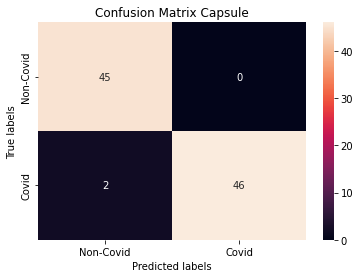

In [75]:
confusion_matrix=sklearn.metrics.confusion_matrix(Y_val.argmax(axis=1), ResCapsnet_Binarymodel.predict(X_val).argmax(axis=1))
ax= plt.subplot()
sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix Capsule'); 
ax.xaxis.set_ticklabels(['Non-Covid', 'Covid']); ax.yaxis.set_ticklabels(['Non-Covid', 'Covid']);

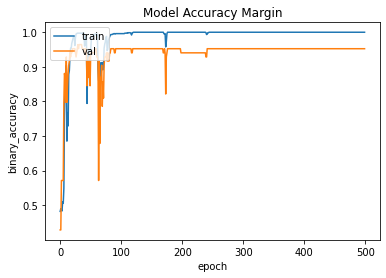

In [76]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Margin')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

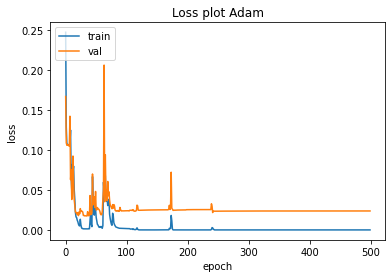

In [77]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss plot Adam')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [78]:
sklearn.metrics.accuracy_score(Y_val.argmax(axis=1),ResCapsnet_Binarymodel.predict(X_val).argmax(axis=1))

0.978494623655914

In [79]:
from sklearn.metrics import classification_report
print(classification_report(Y_val.argmax(axis=1),ResCapsnet_Binarymodel.predict(X_val).argmax(axis=1),target_names=['Non-Covid','Covid']))

              precision    recall  f1-score   support

   Non-Covid       0.96      1.00      0.98        45
       Covid       1.00      0.96      0.98        48

    accuracy                           0.98        93
   macro avg       0.98      0.98      0.98        93
weighted avg       0.98      0.98      0.98        93



In [51]:
extracted_features_train=base_output
extracted_features_train=extracted_features_train.reshape(base_output.shape[0],-1)
extracted_features_train.shape

(837, 100352)

In [52]:
extracted_features_test=X_val
extracted_features_test=extracted_features_test.reshape(X_val.shape[0],-1)
extracted_features_test.shape

(93, 100352)

In [53]:
from sklearn.ensemble import RandomForestClassifier as RF
RF_model=RF(n_estimators=51,random_state=42)
RF_model.fit(extracted_features_train,Y_train.argmax(axis=1))[:1]
RF_predictions=RF_model.predict_proba(extracted_features_test)
print("Accuracy= ",sklearn.metrics.accuracy_score(Y_val.argmax(axis=1),RF_model.predict(extracted_features_test)))

Accuracy=  0.9354838709677419


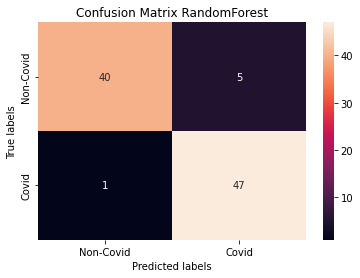

In [54]:
confusion_matrix=sklearn.metrics.confusion_matrix(Y_val.argmax(axis=1),RF_model.predict(extracted_features_test))
ax= plt.subplot()
sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix RandomForest'); 
ax.xaxis.set_ticklabels(['Non-Covid', 'Covid']); ax.yaxis.set_ticklabels(['Non-Covid', 'Covid']);

In [55]:
from sklearn.metrics import classification_report
print(classification_report(Y_val.argmax(axis=1), RF_model.predict(extracted_features_test), target_names=['Non-Covid','Covid']))

              precision    recall  f1-score   support

   Non-Covid       0.98      0.89      0.93        45
       Covid       0.90      0.98      0.94        48

    accuracy                           0.94        93
   macro avg       0.94      0.93      0.94        93
weighted avg       0.94      0.94      0.94        93



In [56]:
#we will now input the extracted features into Support Vector Machines 
from sklearn import svm
SVM_model=svm.SVC(kernel='linear')
SVM_model.fit(extracted_features_train,Y_train.argmax(axis=1))


SVC(kernel='linear')

In [57]:
SVM_predictions=SVM_model.decision_function(extracted_features_test)
t=SVM_model.predict(extracted_features_test)

In [58]:
print("Accuracy= ",sklearn.metrics.accuracy_score(Y_val.argmax(axis=1),t))

Accuracy=  0.978494623655914


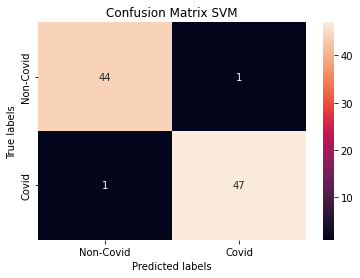

In [59]:
confusion_matrix=sklearn.metrics.confusion_matrix(Y_val.argmax(axis=1),t)
ax= plt.subplot()
sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix SVM'); 
ax.xaxis.set_ticklabels(['Non-Covid', 'Covid']); ax.yaxis.set_ticklabels(['Non-Covid', 'Covid']);

In [60]:
from sklearn.metrics import classification_report
print(classification_report(Y_val.argmax(axis=1), t, target_names=['Non-Covid','Covid']))

              precision    recall  f1-score   support

   Non-Covid       0.98      0.98      0.98        45
       Covid       0.98      0.98      0.98        48

    accuracy                           0.98        93
   macro avg       0.98      0.98      0.98        93
weighted avg       0.98      0.98      0.98        93



In [61]:
from sklearn.neural_network import MLPClassifier

#Initializing the MLPClassifier
classifier = MLPClassifier(hidden_layer_sizes=(50,50,25), max_iter=300,activation = 'relu',solver='adam',random_state=1)
classifier.fit(extracted_features_train,Y_train.argmax(axis=1))

MLPClassifier(hidden_layer_sizes=(50, 50, 25), max_iter=300, random_state=1)

In [62]:
tt=classifier.predict(extracted_features_test)

In [63]:
pred_mlp = classifier.predict_proba(extracted_features_test)
print("Accuracy= ",sklearn.metrics.accuracy_score(Y_val.argmax(axis=1),tt))

Accuracy=  0.946236559139785


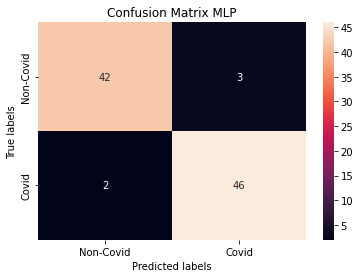

In [64]:
confusion_matrix=sklearn.metrics.confusion_matrix(Y_val.argmax(axis=1),tt)
ax= plt.subplot()
sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix MLP'); 
ax.xaxis.set_ticklabels(['Non-Covid', 'Covid']); ax.yaxis.set_ticklabels(['Non-Covid', 'Covid']);

In [65]:
from sklearn.metrics import classification_report
print(classification_report(Y_val.argmax(axis=1), classifier.predict(extracted_features_test), target_names=['Non-Covid','Covid']))

              precision    recall  f1-score   support

   Non-Covid       0.95      0.93      0.94        45
       Covid       0.94      0.96      0.95        48

    accuracy                           0.95        93
   macro avg       0.95      0.95      0.95        93
weighted avg       0.95      0.95      0.95        93



In [66]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf = clf.fit(extracted_features_train,Y_train.argmax(axis=1))
pred_tree=clf.predict_proba(extracted_features_test)
print("Accuracy= ",sklearn.metrics.accuracy_score(Y_val.argmax(axis=1),clf.predict(extracted_features_test)))

Accuracy=  0.7311827956989247


In [67]:
from sklearn.metrics import classification_report
print(classification_report(Y_val.argmax(axis=1), clf.predict(extracted_features_test), target_names=['Non-Covid','Covid']))

              precision    recall  f1-score   support

   Non-Covid       0.73      0.71      0.72        45
       Covid       0.73      0.75      0.74        48

    accuracy                           0.73        93
   macro avg       0.73      0.73      0.73        93
weighted avg       0.73      0.73      0.73        93



In [68]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3)
model = model.fit(extracted_features_train,Y_train.argmax(axis=1))
pred_knn=model.predict_proba(extracted_features_test)
print("Accuracy= ",sklearn.metrics.accuracy_score(Y_val.argmax(axis=1),model.predict(extracted_features_test)))

Accuracy=  0.7634408602150538


In [69]:
from sklearn.metrics import classification_report
print(classification_report(Y_val.argmax(axis=1), model.predict(extracted_features_test), target_names=['Non-Covid','Covid']))

              precision    recall  f1-score   support

   Non-Covid       0.68      0.96      0.80        45
       Covid       0.93      0.58      0.72        48

    accuracy                           0.76        93
   macro avg       0.81      0.77      0.76        93
weighted avg       0.81      0.76      0.76        93



In [70]:
from sklearn.metrics import classification_report
print(classification_report(Y_val.argmax(axis=1), model.predict(extracted_features_test), target_names=['Non-Covid','Covid']))

              precision    recall  f1-score   support

   Non-Covid       0.68      0.96      0.80        45
       Covid       0.93      0.58      0.72        48

    accuracy                           0.76        93
   macro avg       0.81      0.77      0.76        93
weighted avg       0.81      0.76      0.76        93



In [80]:
from sklearn.metrics import roc_curve


fpr_rf, tpr_rf,thresholds_RF_model= roc_curve(Y_val.argmax(axis=1), RF_predictions[:,1:])
fpr_svm, tpr_svm,thresholds_SVM_model = roc_curve(Y_val.argmax(axis=1), SVM_predictions)
fpr_capsule,tpr_capsule,thresholds_keras=roc_curve(Y_val.argmax(axis=1),pred[:,1:])
fpr_mlp,tpr_mlp,thresholds_keras=roc_curve(Y_val.argmax(axis=1),pred_mlp[:,1:])
fpr_tree,tpr_tree,thresholds_clf=roc_curve(Y_val.argmax(axis=1),pred_tree[:,1:])
fpr_knn,tpr_knn,thresholds_knn=roc_curve(Y_val.argmax(axis=1),pred_knn[:,1:])

In [81]:
from sklearn.metrics import auc
auc_rf = auc(fpr_rf, tpr_rf)
auc_svm = auc(fpr_svm, tpr_svm)
auc_capsule=auc(fpr_capsule,tpr_capsule)
auc_mlp=auc(fpr_mlp,tpr_mlp)
auc_tree=auc(fpr_tree,tpr_tree)
auc_knn=auc(fpr_knn,tpr_knn)

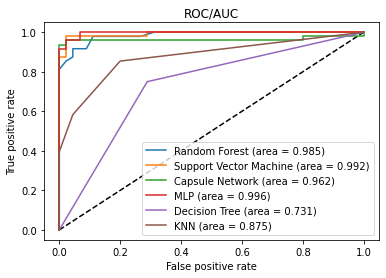

In [82]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='Random Forest (area = {:.3f})'.format(auc_rf))
plt.plot(fpr_svm, tpr_svm, label='Support Vector Machine (area = {:.3f})'.format(auc_svm))
plt.plot(fpr_capsule, tpr_capsule, label='Capsule Network (area = {:.3f})'.format(auc_capsule))
plt.plot(fpr_mlp, tpr_mlp, label='MLP (area = {:.3f})'.format(auc_mlp))
plt.plot(fpr_tree, tpr_tree, label='Decision Tree (area = {:.3f})'.format(auc_tree))
plt.plot(fpr_knn, tpr_knn, label='KNN (area = {:.3f})'.format(auc_knn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC/AUC')
plt.legend(loc='best')
plt.show()